In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import WMAP9
from scipy.optimize import fsolve
import pandas as pd
from scipy.stats import rv_continuous
from scipy.integrate import quad

plt.rcParams['font.family'] = 'monospace'

In [2]:
def semi_a_from_theta(z, dtheta):
    """return semi major axis in kpc
        from Ryden eq. 7.33"""
    dA = (WMAP9.angular_diameter_distance(z)/u.radian).to(u.kpc/u.arcsec)
    semi_a = dA*dtheta/2
    return semi_a.to(u.kpc) 

def r_effective(m_gal):
    """return galaxy effective radius in pc
        from abringhausen, Hilker & Kroupa (2008) Eq. 4"""
    #r_gal = 2.95*(m_gal/(1e6*u.Msun))**0.596
    r_gal = np.maximum(2.95*(m_gal/(1e6*u.Msun))**0.596,34.8*(m_gal/(1e6*u.Msun))**0.399)
    return r_gal/100*u.kpc

def velocity_disp(m_gal):
    """return velocity dispersion in km/s
        from Binney above eq. 8.2, approximating sigma=v_typ
        from Zahid et al. 2016 Eq 5 and Table 1 fits; assume Mb > e10.3"""
    #sigma = np.sqrt(m_gal*const.G/r_gal/2)
    logsigmab = 2.2969 #\pm 0.0006; in km/s
    alpha2 = 0.299 #\pm 0.001
    logAns = logsigmab + alpha2*np.log10(m_gal/(1e11*u.Msun))
    return 10**logAns*(u.km/u.s)

def coulombLog(semi_a,sigma,m_bh):
    """return coulomb log
        from Binney eq. 8.2"""
    clog = np.log10(semi_a*sigma**2/(const.G*m_bh))
    return clog.to('')

def timescale(a,m_gal,m_bh):
    """return dynamical timescale in Myr
        from Binney eq. 8.12"""
    sigma = velocity_disp(m_gal)
    clog = coulombLog(a,sigma,m_bh)
    prefactor = 19*u.Gyr/clog
    len_term = (a/(5*u.kpc))**2
    vel_term = sigma/(200*u.km/u.s)
    mass_term = 1e8*u.Msun/m_bh
    t = prefactor*len_term*vel_term*mass_term
    return t.to(u.Myr)

def calA(time,sigma,m_bh):
    """returns a term in t_dyn equ., used in func() below to calculate a from t"""
    vel_term = sigma/(200*u.km/u.s)
    mass_term = 1e8*u.Msun/m_bh
    a_term = time/ (19*u.Gyr)*(5*u.kpc)**2/vel_term/mass_term
    return a_term


def func(x, *args):
    """solve for a given t_dyn"""
    sigma = args[0]
    m_bh = args[1]
    time = args[2]
    constant = (sigma**2/(const.G*m_bh)).to(u.kpc**-1).value
    aterm =calA(time,sigma,m_bh).to(u.kpc**2)
    return x**2/np.log10(x*constant) - aterm.value


def da_dt(a,sigma,m_bh):
    """returns da/dt evaluated at a(kpc)
    analytic result from mathematica"""
    vel_term = sigma/(200*u.km/u.s)
    mass_term = 1e8*u.Msun/m_bh
    F = (19*u.Gyr)/(5*u.kpc)**2*vel_term*mass_term
    prefactor = (sigma*sigma/(const.G*m_bh)).to(1/u.kpc).value
    av = a.value
    dt_da = F*a*np.log(10)*(2*np.log(av*prefactor)-1)/np.log(av*prefactor)**2
    return 1/dt_da


def dt_dz(z):
    """returns dz/dt """
    dz_dt = (1+z)*WMAP9.H0-WMAP9.H(1/(1+z))
    return 1/dz_dt


def f(logM):
    """double Schechter PDF for sampling from SMF, params from Muzzin, et al 2013"""
    logMstar = 10.97
    phiStar1 = 16.27
    phiStar2 = 9.47
    alpha1 = -0.53
    alpha2 = -1.37
    term0 = np.log(10)*np.exp(-10**(logM-logMstar))
    term1 = phiStar1 *10**((logM-logMstar)*(1+alpha1))
    term2 = phiStar2 *10**((logM-logMstar)*(1+alpha2))
    return term0*(term1+term2)


class smf_gen(rv_continuous):
    "Stellar mass function pdf object"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.scale, _ = quad(f, self.a, self.b)
    def _pdf(self, logM):
        return f(logM)/self.scale


def sample_smf_gal(n=1000, an=10, bn=11):
    """Sample galaxy stellar mass from double Schechter with params from Muzzin et. al, 2013
       Returns ensemble of n galaxy masses, corresponding pdf values"""    
    smf = smf_gen(a=an, b=bn)
    mgal = smf.rvs(size=n)
    pdf = smf.pdf(mgal)
    return mgal*1e11*u.Msun, pdf


def plot_mgal(mgal_smf,pdf):
    """plot mgal distribution sampled from SMF"""
    fig,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].scatter(mgal_smf,pdf, s=0.1)
    ax[0].set_yscale('log')
    ax[1].hist(mgal_smf)
    [ax[i].set_title(['PDF','Galaxy sample'][i]) for i in range(2)]
    [ax[i].set_ylabel(['Probability','Number of galaxies'][i]) for i in range(2)]
    [ax[i].set_xlabel('M_gal/Msun') for i in range(2)]
    fig.tight_layout();
    

def blackhole_mass(m_gal):
    """returns black hole mass from m-sigma relation"""
    sigma = velocity_disp(m_gal).to(u.km/u.s).value
    m_bh = 1.9*(sigma/200)**5.1
    return m_bh*10**8*u.Msun


def stop_df(sigma, a, mbh):
    """check if the system has reached end of dynamical friction, for now assumes bhs have same mass
       returns a boolean, True=ends df"""
    a_end = (const.G*mbh*2/sigma**2).to('kpc').value
    if a_end > a:
        return True
    else:
        return False
    
    
def evolveA_withz(a0s,sigma,m_bh,numsteps):
    """evolve semi major axis from z=0.5 to z=0.18, stops when reached influence radius
        returns nx10 array of semimajor along zs for n AGNs"""
    # initiate array to store separation values for n AGNs
    agns = []
    zs = np.linspace(0.5,0.18,numsteps)
    for j in range(len(m_bh)):
        seps = np.zeros(numsteps)
        a0 = a0s[j]
        seps[0] = a0.value
        for i in range(1,numsteps):
            dadt = da_dt(a0,sigma[j],m_bh[j])
            dtdz = dt_dz(zs[i-1])
            seps[i] = (a0+dadt*dtdz*(zs[i]-zs[i-1])).to(u.kpc).value
            # check if reach influence radius
            if stop_df(sigma[j], seps[i], m_bh[j]):
                # force remove last point if is negative
                if seps[i] < 0:
                    seps[i]=0
                break 
            else:
                a0 = seps[i]*u.kpc    
        agns.append(seps)
    return agns, zs


def make_sim_dataframe(semi_as,a0s,m_gal,m_bh):
    """given semi_as array, returns df with sim info and
        df_inrange: in range of Magellan 0.77-3.07 kpc"""
    # find min-max of Magellan
    amin = (WMAP9.angular_diameter_distance(0.18)/u.rad/2*0.5*u.arcsec).to('kpc')
    amax = (WMAP9.angular_diameter_distance(0.18)/u.rad/2*2*u.arcsec).to('kpc')
    # cropping semi_as array to last non-zero value
    max_ind = [semi_as[i].nonzero()[0][-1] for i in range(len(semi_as))]
    semi_as = [semi_as[i][:max_ind[i]] for i in range(len(semi_as))]
    af = [semi_as[i][-1] for i in range(len(semi_as))]
    df = pd.DataFrame([semi_as,a0s.value,af,m_gal,m_bh], index=['seps','a0','af','m_gal', 'm_bh']).T
    df_inrange =  df[(amin <= df['af']) & (df['af'] <= amax)].reset_index(drop=True)
    return df, df_inrange


def plot_sep(df, df_inrange,suptit,zs,ylabel):
    """plot semi_a vs z, histogram of a0 and af"""
    fig,ax = plt.subplots(1,3,figsize=(12,4))

    # plot z vs. a
    [ax[0].plot(df['seps'].iloc[i],zs[:len(df['seps'].iloc[i])],"lightblue", alpha=0.5) for i in range(len(df))]
    [ax[0].plot(df_inrange['seps'].loc[i],zs[:len(df_inrange['seps'].iloc[i])],"blue", alpha=0.1) for i in range(len(df_inrange))]

    # histogram of as for whole sample
    ax[1].hist(df.a0,color="steelblue",histtype="step")
    ax[1].hist(df.af,color="salmon", histtype="step")

    # histogram of as for sample in magellan range
    ax[2].hist(list(df_inrange.a0),color="steelblue",histtype="step")
    ax[2].hist(list(df_inrange.af),color="salmon", histtype="step")

    # labels, etc.
    [ax[i].set_xlabel('Semi major axis(kpc)') for i in range(3)]
    ax[0].set_ylabel(ylabel)
    [ax[i].set_ylabel("Number of AGNs") for i in [1,2]]

    legend_handles0 = [plt.Line2D([], [], color='blue', label='in Magellan range'),
                      plt.Line2D([], [], color='steelblue', label='whole ensemble')]
    legend_handles1 = [plt.Line2D([], [], color='salmon', label='final'),
                      plt.Line2D([], [], color='steelblue', label='initial')]
    [ax[i].legend(handles=[legend_handles0, legend_handles1, legend_handles1][i]) for i in range(3)]

    ax[1].set_title(f"Whole ensemble, n={len(df)}")
    ax[2].set_title(f"In Magellan range, n={len(df_inrange)}")
    fig.suptitle(suptit)
    fig.tight_layout()
    ; 

# Try J1010 

In [3]:
# try j1010
z_1010=0.198
dtheta_1010 = 0.13*u.arcsec
m_gal_1010 = 1e11*u.Msun
m_bh_1010 = 4e8*u.Msun

a_1010 = semi_a_from_theta(z_1010,dtheta_1010)
timescale(a_1010,m_gal_1010,m_bh_1010)


<Quantity 12.62121584 Myr>

# Evolve DF with redshift

In [177]:
def ini_sim_mass(seed,mgal_min=0.7, mgal_max=1.5, num_gals=1000):
    """returns arrays of galaxy mass, black hole mass, and PDF of galaxy mass"""
    np.random.seed(seed)
    mgal_smf,pdf = sample_smf_gal(n=num_gals, an=mgal_min, bn=mgal_max)
    m_bh = blackhole_mass(mgal_smf)
    return mgal_smf,m_bh,pdf
    
def main_df_z(seed,mgal_smf,m_bh,z0=0.5, zf=0.18, a_min=5, a_max=10, numsteps=10):
    """evolve thru DF including redshift given galaxy and black hole mass
       returns dataframes and redshift array"""
    np.random.seed(1)
    zs = np.linspace(z0,zf,numsteps)
    a0s = np.random.uniform(a_min,a_max,size=len(m_bh))*u.kpc
    sigma = velocity_disp(mgal_smf)
    semi_as,zs = evolveA_withz(a0s,sigma,m_bh,numsteps)
    df, df_inrange = make_sim_dataframe(semi_as,a0s,mgal_smf,m_bh)
    return df,df_inrange,zs
    

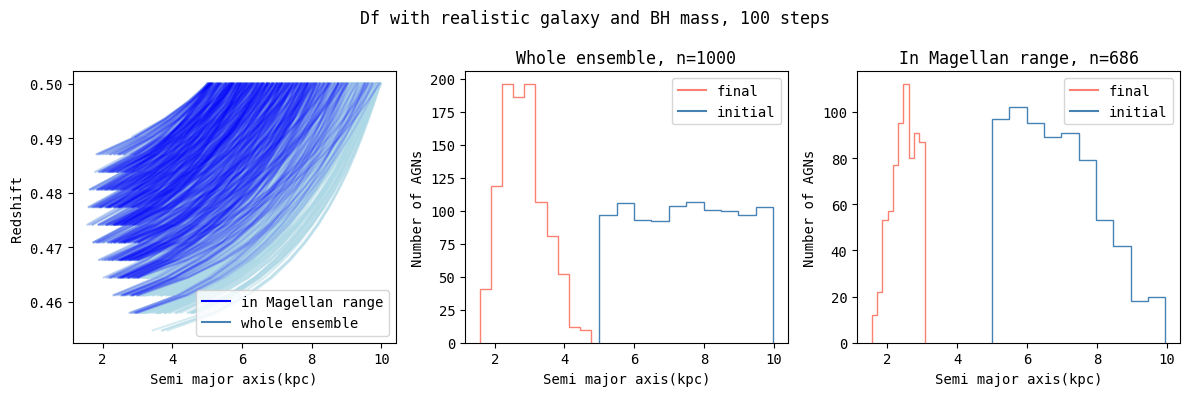

In [182]:
mgal_smf,m_bh,pdf = ini_sim_mass(seed=2,mgal_min=0.7, mgal_max=1.5, num_gals=1000)
df,df_inrange,zs = main_df_z(seed=2, mgal_smf=mgal_smf,m_bh=m_bh,numsteps=100)
plot_sep(df,df_inrange,zs=zs,suptit="Df with realistic galaxy and BH mass, 100 steps",ylabel="Redshift")

# forward convergence

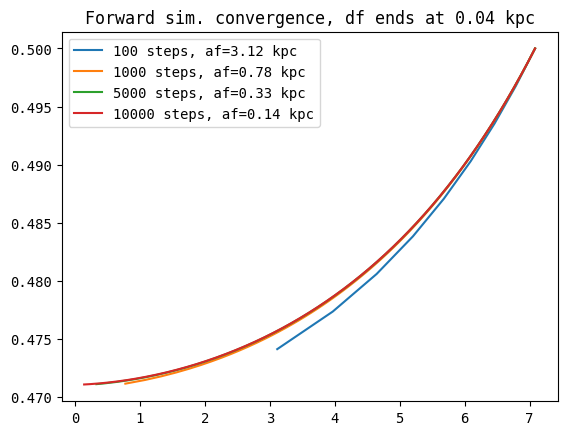

In [179]:
mgal_smf,m_bh,pdf = ini_sim_mass(seed=2,mgal_min=0.7, mgal_max=1.5, num_gals=1)
for nstep in [100,1000,5000,10000]:
    df,df_inrange,zs = main_df_z(seed=2, mgal_smf=mgal_smf,m_bh=m_bh,numsteps=nstep)
    plt.plot(df.seps[0],zs[:len(df.seps[0])],label=f"{nstep} steps, af={df.seps[0][-1]:.2f} kpc")
#plt.xlim((0.45,0.5))
dfmax = (const.G*m_bh*2/velocity_disp(mgal_smf)**2).to('kpc').value
plt.title(f"Forward sim. convergence, df ends at {dfmax[0]:.2f} kpc")
plt.legend();

# evolve without redshift

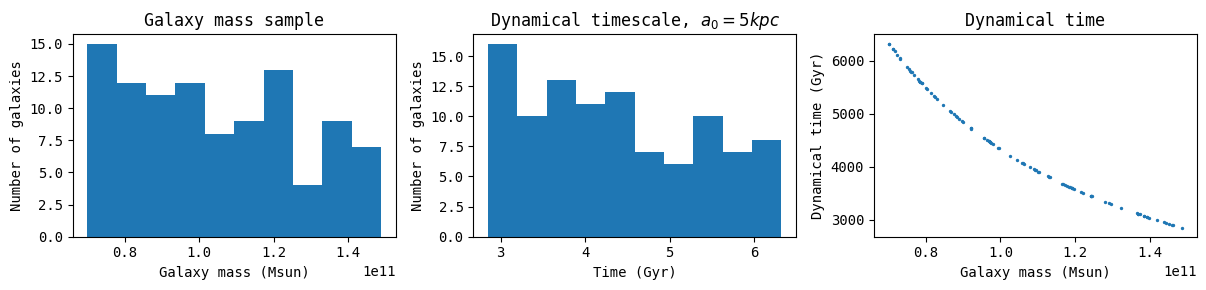

In [3]:
np.random.seed(1)
ngal = 100
numsteps=100
mgal_smf,pdf = sample_smf_gal(n=ngal, an=0.7, bn=1.5)
#mgal_smf = np.linspace(0.7,1.5,ngal)*1e11*u.Msun
m_bh = blackhole_mass(mgal_smf)
timescales = timescale(5*u.kpc,mgal_smf,m_bh)

fig,ax = plt.subplots(1,3,figsize=(12,3))

ax[0].hist(mgal_smf)
ax[0].set_title("Galaxy mass sample")
ax[0].set_xlabel("Galaxy mass (Msun)")
ax[0].set_ylabel("Number of galaxies")

ax[1].hist(timescales/1000)
ax[1].set_title("Dynamical timescale, $a_0=5kpc$")
ax[1].set_xlabel("Time (Gyr)")
ax[1].set_ylabel("Number of galaxies")


ax[2].scatter(mgal_smf,timescales,s=2)
ax[2].set_title("Dynamical time")
ax[2].set_xlabel("Galaxy mass (Msun)")
ax[2].set_ylabel("Dynamical time (Gyr)")
fig.tight_layout()

In [125]:
def evolveA_noZ(a0s,sigma,m_bh,numsteps,tf,t0):
    """evolve semi major axis in time"""
    # initiate array to store separation values for n AGNs
    agns = []
    ts = np.linspace(tf,t0,numsteps)*u.Gyr 
    for j in range(len(m_bh)):
        seps = np.zeros(numsteps)
        a0 = a0s[j]
        seps[0] = a0.value
        for i in range(1,numsteps):
            dadt = da_dt(a0,sigma[j],m_bh[j])
            seps[i] = (a0+ dadt*(ts[i]-ts[i-1])).to(u.kpc).value
            # check if reach influence radius
            if stop_df(sigma[j], seps[i], m_bh[j]):
                # force remove last point if is negative
                if seps[i] < 0:
                    seps[i]=0
                break 
            else:
                a0 = seps[i]*u.kpc    
        agns.append(seps)
    return agns, ts


ngal = 1000
numsteps = 100
mgal_smf,pdf = sample_smf_gal(n=ngal, an=0.7, bn=1.5)
m_bh = blackhole_mass(mgal_smf)
a0s = np.ones(ngal)*5*u.kpc
sigma = velocity_disp(mgal_smf)
semi_asR,times = evolveA_noZ(a0s,sigma,m_bh,numsteps,tf=7,t0=2)


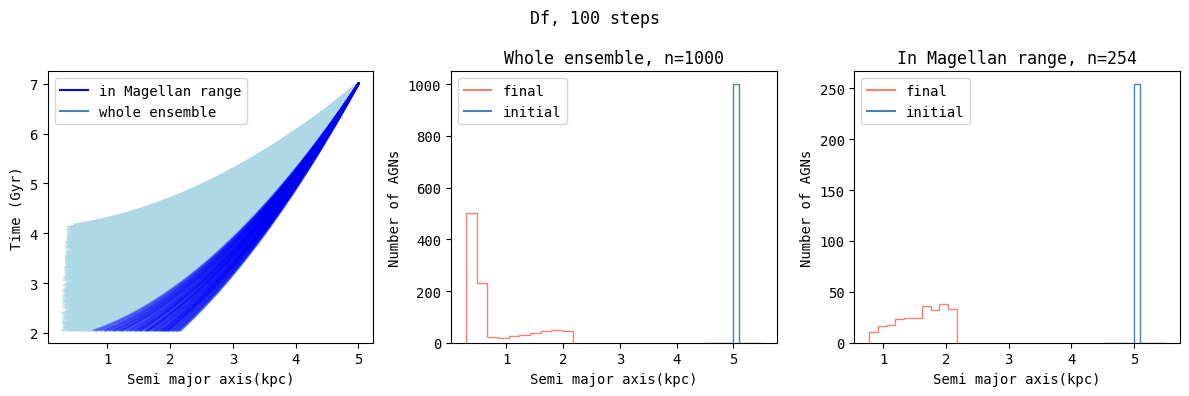

In [129]:
#[plt.plot(semi_asR[i],times) for i in range(ngal)];
df,df_ir = make_sim_dataframe(semi_asR,a0s,mgal_smf,m_bh)
plot_sep(df,df_ir,zs=times,suptit="Df, 100 steps",ylabel="Time (Gyr)")

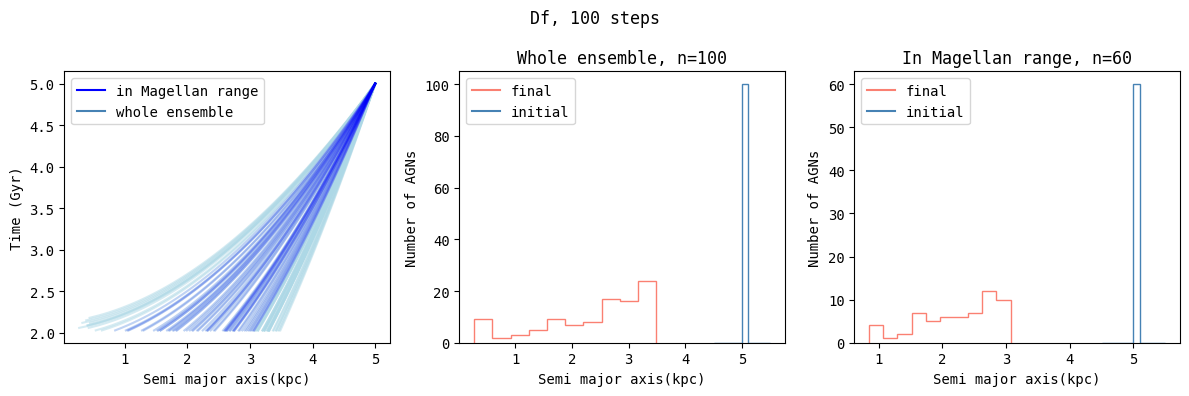

In [130]:
ngal = 100
numsteps = 100
mgal_smf,pdf = sample_smf_gal(n=ngal, an=0.7, bn=1.5)
m_bh = blackhole_mass(mgal_smf)
a0s = np.ones(ngal)*5*u.kpc
sigma = velocity_disp(mgal_smf)
semi_asR52,times52 = evolveA_noZ(a0s,sigma,m_bh,numsteps,tf=5,t0=2)
df52,df_ir52 = make_sim_dataframe(semi_asR52,a0s,mgal_smf,m_bh)
plot_sep(df52,df_ir52,zs=times52,suptit="Df, 100 steps",ylabel="Time (Gyr)")

In [3]:
def evolveA_noZ_toend(a0s,sigma,m_bh,t_ini,deltaT):
    """evolve semi major axis in time"""
    # initiate array to store separation values for n AGNs
    agns = []
    times = [] 
    for j in range(len(m_bh)):
        seps = []
        ts = []
        a0 = a0s[j]
        seps.append(a0.value)
        t0 = t_ini
        ts.append(t0)
        i = 0
        while not stop_df(sigma[j], a0.value, m_bh[j]):
            dadt = da_dt(a0,sigma[j],m_bh[j])
            af = (a0+ dadt*-deltaT*u.Gyr).to(u.kpc)
            tf = t0-deltaT
            seps.append(af.value)
            ts.append(tf)
            a0 = af 
            t0=tf
            i+=1
        agns.append(seps)
        times.append(ts)
    return agns, times


ngal = 5 
a_ini=5
t_start=7
dt=1e-3
#mgal_smf,pdf = sample_smf_gal(n=ngal, an=0.7, bn=1.5)
mgal_smf = np.linspace(0.7,1.5,ngal)*10**11*u.Msun
m_bh = blackhole_mass(mgal_smf)
a0s = np.ones(ngal)*a_ini*u.kpc
sigma = velocity_disp(mgal_smf)
semi_asR,times = evolveA_noZ_toend(a0s,sigma,m_bh,t_ini=t_start,deltaT=dt)


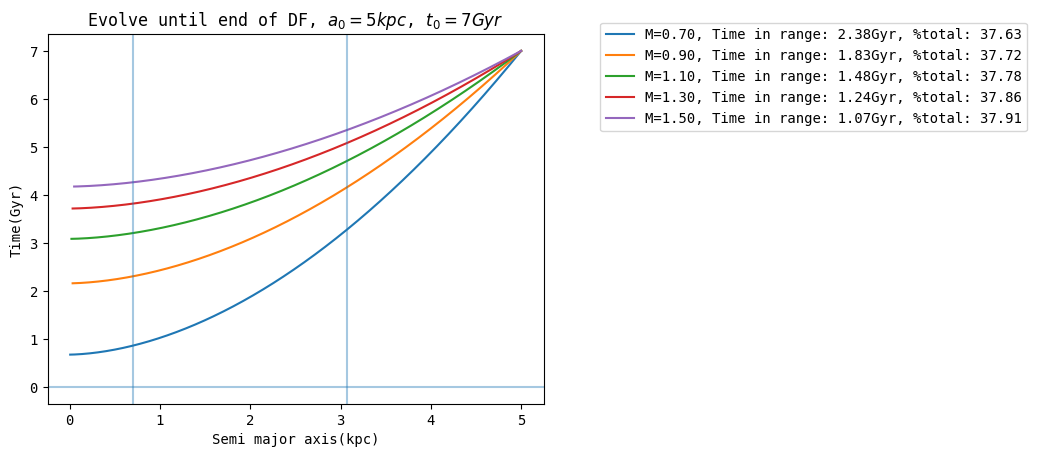

In [4]:
labels=[]
for i in range(ngal):
    sep_array = np.array(semi_asR[i])
    time_array = np.array(times[i])
    indices = np.where((sep_array > 0.77) & (sep_array < 3.07))
    in_mag_time = time_array[indices][0]-time_array[indices][-1]
    total_time = time_array[0]-time_array[-1]
    labels.append(f'M={mgal_smf[i].value/1e11:.2f}, Time in range: {in_mag_time:.2f}Gyr, %total: {in_mag_time/total_time*100:.2f}')
[plt.plot(semi_asR[i],times[i],label=labels[i]) for i in range(ngal)]
#[plt.plot(semi_asR[i],times[i]) for i in range(ngal)]
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("Semi major axis(kpc)")
plt.ylabel("Time(Gyr)")
plt.title(f"Evolve until end of DF, $a_0={a_ini} kpc$, $t_0={t_start} Gyr$")
plt.axvline(x=0.7,alpha=0.4)
plt.axvline(x=3.07,alpha=0.4)
plt.axhline(y=0, alpha=0.4)

# Evolve from a0=R_eff, sample z from merger rate

In [128]:
def N_zMu(z,M,mu):
    """Sample redshift from merger rate in Illustris
       given mass M of descendant galaxy right after merger and progenitor mass ratio mu"""
    M0 = 2e11*u.Msun
    A0 = 10**-2.2287
    eta = 2.4644
    alpha0 = 0.2241
    alpha1 = -1.1759
    beta0 = -1.2595
    beta1 = 0.0611
    gamma = -0.0477
    delta0 = 0.7668
    delta1 = -0.4695
    Az = A0*(1+z)**eta
    alphaz = alpha0*(1+z)**alpha1
    betaz = beta0*(1+z)**beta1
    deltaz = delta0*(1+z)**delta1
    N = Az*(M/(1e10*u.Msun))**alphaz*(1+(M/M0)**deltaz)*mu**(betaz+gamma*np.log10(M/(1e10*u.Msun)))
    return N
    
    
class mergerRate_gen(rv_continuous):
    "Merger rate by redshift pdf object"
    def __init__(self,M,mu, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.M = M
        self.mu = mu
        self.scale, _ = quad(N_zMu, self.a, self.b,args=(M,mu))
    def _pdf(self, z):
        return N_zMu(z,self.M,self.mu)/self.scale
    
    
def sample_z(M, mu, n=1000, an=0.2, bn=1):
    """"""    
    mrf = mergerRate_gen(M, mu, a=an, b=bn)
    z0s = mrf.rvs(size=n)
    pdf = mrf.pdf(z0s)
    return z0s, pdf

In [130]:
z0s, pdf=sample_z(M=mgalmax*2,mu=1,n=100)

In [203]:
def integrate_over_mu(z, M, mu_min, mu_max, args=()):
    """Integrate N_zMu over mu from mu_min to mu_max"""
    integrand = lambda mu: N_zMu(z, M, mu)
    result, _ = quad(integrand, mu_min, mu_max, args=args)
    return result

# Example usage:
z = 0.1
M = 1e10*u.Msun
mu_min = 1/10**np.arange(0,5)
mu_max = 10

#[plt.plot(mu_min[i],integrate_over_mu(z, M, mu_min[i], mu_max)) for i in range(len(mu_min))]
plt.scatter(z0s,pdf,s=0.1)

In [ ]:
np.random.seed(1)
mgal_smf,pdf = sample_smf_gal(n=1000, an=0.7, bn=1.5)
np.random.seed(1)
n=1000
numsteps=100
a0s = r_effective(mgal_smf)
sigma_R = velocity_disp(mgal_smf)
m_bh_real = blackhole_mass(mgal_smf)

In [57]:
da_dt(a0s[0],velocity_disp(mgal_smf[-1]),m_bh[-1])

<Quantity 0.97974855 kpc / Gyr>

In [65]:
timescale(a0s[0],mgal_smf[-1],m_bh[-1])

<Quantity 2825.82034765 Myr>

In [6]:
WMAP9.lookback_time(0.20)-WMAP9.lookback_time(0.18)

<Quantity 0.21674613 Gyr>